In [2]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions, ColorSchemes

In [3]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [4]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

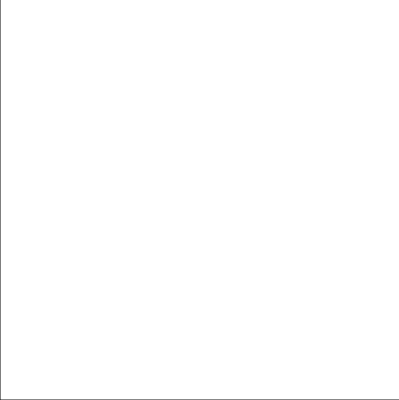

In [5]:
# Define the plot
num_points = 100

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / num_points for j in 0:num_points, i in 0:num_points]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / num_points for j in 0:num_points, i in 0:num_points]

grid = range(0, stop=1, length=(num_points + 1))
plot_size = (400, 400) .* 1
using Plots.Measures
plt = heatmap(xlims=domain[1], ylims=domain[2], color=:viridis, size=plot_size, grid=false, ticks=false, margins=-2mm, cb=:none)

In [6]:
ops = gaussian_operators_2D(0.035, plt_grid_x1, plt_grid_x2)

# ops = fourier_operators_2D(6, plt_grid_x1, plt_grid_x2)

Operators(var"#ϕ#32"{Int64}(Core.Box(var"#gauss2D#31"{Float64, Matrix{Float64}, Float64}(0.012992240252399619, Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.01; … ; 1.0 0.99; 1.0 1.0], 408.1632653061224)), 10201), var"#Φ#33"{var"#ϕ#32"{Int64}, Int64}(var"#ϕ#32"{Int64}(Core.Box(var"#gauss2D#31"{Float64, Matrix{Float64}, Float64}(0.012992240252399619, Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.01; … ; 1.0 0.99; 1.0 1.0], 408.1632653061224)), 10201), Core.Box(var"#gauss2D#31"{Float64, Matrix{Float64}, Float64}(0.012992240252399619, Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.01; … ; 1.0 0.99; 1.0 1.0], 408.1632653061224)), 10201), var"#adjΦ#38"{Matrix{Float64}, Matrix{Float64}, var"#adjΦ#30#39"{var"#ϕ#32"{Int64}}}([0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0; … ; 0.0 0.01 … 0.99 1.0; 0.0 0.01 … 0.99 1.0], [0.0 0.0 … 0.0 0.0; 0.01 0.01 … 0.01 0.01; … ; 0.99 0.99 … 0.99 0.99; 1.0 1.0 … 1.0 1.0], var"#adjΦ#30#39"{var"#ϕ#32"{Int64}}(var"#ϕ#32"{Int64}(Core.Box(v

## Spurious spikes for degenerate pre-certificate

In [7]:
function add_noise(y0, noise_level, seed=1)
    Random.seed!(seed)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

add_noise (generic function with 2 methods)

In [8]:
x0 = [[0.47, 0.53], [0.5, 0.5]]
a0 = [1.0, -1.0]

y0 = ops.Φ(x0..., a0)

μ0 = DiscreteMeasure(x0, a0)

ηV = pre_certificate(μ0, ops)

display(maximum(ηV))

1.3907166742013795

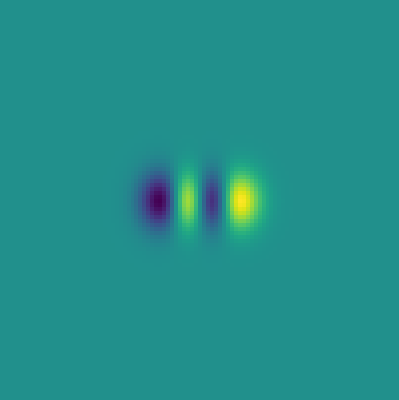

In [9]:
plt_cert = deepcopy(plt)

heatmap!(plt_cert, grid, grid, ηV ./ maximum(ηV), color=:viridis)
# scatter!(plt_cert, inset=(bbox(0, 0, 1, 1, :bottom)), bgcolor=:transparent,
#     μ0.x...,
#     zcolor=μ0.a,
#     color=cgrad(ColorSchemes.diverging_linear_bjr_30_55_c53_n256.colors),
#     legend=:none, grid=false, ticks=false,
#     label=L"μ_0", marker=:square,
#     markersize=8, markerstrokewidth=1)

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:00


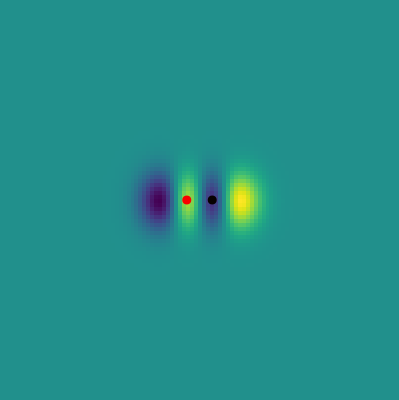

In [212]:
λ = 0.000038

prob = BLASSO(y0, ops, domain, λ)
solve!(prob, :SFW, options=Dict(:maxits => 6))

plt_spurious = deepcopy(plt_cert)

red_cmap = cgrad([RGB(0, 0, 0), RGB(1, 0, 0)])

scatter!(plt_spurious, 
    # inset=(bbox(0, 0, 1, 1, :bottom)), bgcolor=:transparent,
    prob.μ.x...,
    zcolor=prob.μ.a,
    color=red_cmap,
    marker=:circle,
    legend=:none, grid=false, ticks=:none,
    markersize=5, markerstrokewidth=0)

In [170]:
prob.μ.x[1]

2-element Vector{Float64}:
 0.46840684746596756
 0.5315362450565327

In [210]:
prob.y = add_noise(y0, 0.001)
prob.λ = 0.000035
solve!(prob, :SFW, options=Dict(:maxits => 10))

SFW iterations: 100%|███████████████████████████████████| Time: 0:00:04


BLASSO([4.987138153248855e-8, 2.2418647243159985e-7, -4.797880183292504e-7, 3.7572505393534365e-8, 8.743363791020409e-7, -1.2695299831121591e-6, 1.4167579843070176e-7, 6.968484859315835e-7, -2.246875689738679e-6, -1.5235468233953967e-6  …  -9.566587269539663e-7, -3.85064171502315e-7, 1.1871514300180783e-6, 5.197444643046121e-8, -5.685756303316005e-7, -5.111432531999481e-7, -7.682539998252657e-7, -9.641997908681142e-7, -3.118937535170535e-7, 7.827233089349342e-7], Operators(var"#ϕ#32"{Int64}(Core.Box(var"#gauss2D#31"{Float64, Matrix{Float64}, Float64}(0.012992240252399619, Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.01; … ; 1.0 0.99; 1.0 1.0], 408.1632653061224)), 10201), var"#Φ#33"{var"#ϕ#32"{Int64}, Int64}(var"#ϕ#32"{Int64}(Core.Box(var"#gauss2D#31"{Float64, Matrix{Float64}, Float64}(0.012992240252399619, Core.Box(#= circular reference @-2 =#), [0.0 0.0; 0.0 0.01; … ; 1.0 0.99; 1.0 1.0], 408.1632653061224)), 10201), Core.Box(var"#gauss2D#31"{Float64, Matrix{Float64}, Float

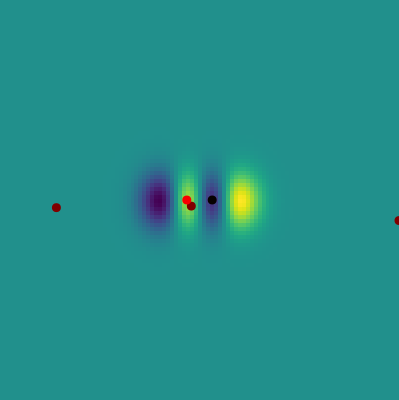

In [211]:
plt_spurious_ns = deepcopy(plt_cert)
scatter!(plt_spurious_ns, prob.μ.x...,
    zcolor=prob.μ.a,
    color=red_cmap,
    marker=:circle, label="",
    legend=:none, grid=false, ticks=:none,
    markersize=5, markerstrokewidth=0)


In [ ]:
# savefig(plt_spurious, "../../figures/PreCertificates/Spurious.svg")
# savefig(plt_spurious_ns, "../../figures/PreCertificates/Spurious_noise.svg")

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\figures\\PreCertificates\\Spurious.svg"